In [ ]:
#assumptions that will break if we use MCTS for play traces in this code
#1. Turn wont be either 0 or 1
#2. Cant just copy the final two rows to extend round number to maxNoOfRounds

#comments: So play traces for a given strategy will change dependent on the opponent's strategy, e.g. evolution of 
#bigmoney deck is different if it is played vs another bigmoney startegy as opposed to say a witch strategy which will 
#introduce curse cards into the bigmoney trace

In [2]:
import pandas as pd
import pdb
import math
import matplotlib.pyplot as plt
from sklearn.manifold import MDS 
import itertools
pd.set_option('display.max_rows', 100)
noPlayers = 2

In [3]:
data  = pd.read_csv("data/featureslogfile.txt", sep = '\t')

In [4]:
print(data.columns)

Index(['GameID', 'Player', 'Round', 'Turn', 'CurrentScore', 'SCORE',
       'SCORE_ADV', 'ORDINAL', 'OUR_TURN', 'HAS_WON', 'FINAL_ORD', 'ROUND',
       'CURSE', 'ESTATE', 'DUCHY', 'PROVINCE', 'COPPER', 'SILVER', 'GOLD',
       'CELLAR', 'CHAPEL', 'MOAT', 'HARBINGER', 'MERCHANT', 'VASSAL',
       'VILLAGE', 'WORKSHOP', 'BUREAUCRAT', 'GARDENS', 'MILITIA',
       'MONEYLENDER', 'POACHER', 'REMODEL', 'SMITHY', 'THRONE_ROOM', 'BANDIT',
       'COUNCIL_ROOM', 'FESTIVAL', 'LABORATORY', 'LIBRARY', 'MARKET', 'MINE',
       'SENTRY', 'WITCH', 'ARTISAN', 'PlayerCount', 'TotalRounds',
       'ActionScore', 'Win', 'Ordinal', 'FinalScore'],
      dtype='object')


In [5]:
#check number of games
print(data['GameID'].unique())

[ 2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18. 19.
 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36. 37.
 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51.]


In [6]:
#note that Player field swaps round half way through the tournament when there are two players. Also the GameID starts
#at 2 for some reason
noGamesPerMatchUp = 25
def assignName(gameID, player, noGamesPerMatchUp):
    name = ""
    if gameID < (noGamesPerMatchUp + 2):
        if player == 0:
            name = 'BigMoneyWithGardens'
        else:
            name = 'DoubleWitch'
    else:
        if player == 1:
            name = 'BigMoneyWithGardens'
        else:
            name = 'DoubleWitch'
    return name

In [7]:
#add label for player types
data['PlayerName'] = data.apply(lambda df: assignName(df['GameID'], df['Player'], noGamesPerMatchUp), axis = 1)

In [8]:
#we can only record events each turn so we need to use the final turn in each round for each player to determine their
#deck at the end of the round
print(data['Turn'].unique())
data = data[data['Turn'] == 1]
print(data['Turn'].unique())

[0. 1.]
[1.]


In [9]:
#extract columns of interest 
card_types_in_supply = ['ARTISAN', 'BANDIT', 'BUREAUCRAT', 'CHAPEL', 'FESTIVAL', 'GARDENS', 'SENTRY',
                        'THRONE ROOM', 'WITCH', 'CURSE','WORKSHOP','PROVINCE', 'DUCHY', 'ESTATE', 'GOLD', 'SILVER', 'COPPER']
card_types_BigMoneyWithGardens_vs_DoubleWitch = ['GARDENS', 'WITCH', 'CURSE', 'PROVINCE', 'DUCHY', 'ESTATE', 'GOLD', 'SILVER', 'COPPER']
cols = ['PlayerName', 'Player', 'GameID', 'Round', 'CurrentScore']
cols = cols + card_types_BigMoneyWithGardens_vs_DoubleWitch

In [10]:
#all play taces in a single data frame
traces = data.loc[:, cols]
print(traces)

               PlayerName  Player  GameID  Round  CurrentScore  GARDENS  \
2     BigMoneyWithGardens     0.0     2.0    0.0           3.0      0.0   
3             DoubleWitch     1.0     2.0    0.0           3.0      0.0   
6     BigMoneyWithGardens     0.0     2.0    1.0           3.0      0.0   
7             DoubleWitch     1.0     2.0    1.0           3.0      0.0   
10    BigMoneyWithGardens     0.0     2.0    2.0           3.0      0.0   
...                   ...     ...     ...    ...           ...      ...   
4345  BigMoneyWithGardens     1.0    51.0   16.0           4.0      0.0   
4348          DoubleWitch     0.0    51.0   17.0          21.0      0.0   
4349  BigMoneyWithGardens     1.0    51.0   17.0          10.0      0.0   
4352          DoubleWitch     0.0    51.0   18.0          27.0      0.0   
4353  BigMoneyWithGardens     1.0    51.0   18.0          15.0      0.0   

      WITCH  CURSE  PROVINCE  DUCHY  ESTATE  GOLD  SILVER  COPPER  
2       0.0    0.0       0.0   

In [11]:
#we need to make sure all games have the same number of rounds in them
gameLengths = traces.groupby(['GameID'])['Round'].max()
maxNoOfRounds = int(gameLengths.max()) + 1 #round counter starts at zero
print(maxNoOfRounds)

25


In [12]:
def copy_final_deck_at_game_end(group, roundMax, noPlayers):
    #This function repeatedly copies the final decks of two players at the game end, so that the game is extended to 
    #have roundMax rounds
    final_round = int(group['Round'].max())
    if (roundMax-1) == final_round:
        #in this case we dont need to extend the play trace
        return group
    else:
        final_row_copy = pd.concat([group.iloc[-noPlayers:]] * ((roundMax-1) - final_round), ignore_index=True)
        #we need to update the Round counter so that every other row it increments by one
        final_row_copy['Round'] = [final_round + 1 + i // 2 for i in range(((roundMax-1) - final_round)*2)]
        return pd.concat([group, final_row_copy], ignore_index=True)

In [15]:
extended_traces = traces.groupby('GameID').apply(copy_final_deck_at_game_end, maxNoOfRounds, noPlayers = 2).reset_index(drop = True)
print(extended_traces)

               PlayerName  Player  GameID  Round  CurrentScore  GARDENS  \
0     BigMoneyWithGardens     0.0     2.0    0.0           3.0      0.0   
1             DoubleWitch     1.0     2.0    0.0           3.0      0.0   
2     BigMoneyWithGardens     0.0     2.0    1.0           3.0      0.0   
3             DoubleWitch     1.0     2.0    1.0           3.0      0.0   
4     BigMoneyWithGardens     0.0     2.0    2.0           3.0      0.0   
...                   ...     ...     ...    ...           ...      ...   
2495  BigMoneyWithGardens     1.0    51.0   22.0          15.0      0.0   
2496          DoubleWitch     0.0    51.0   23.0          27.0      0.0   
2497  BigMoneyWithGardens     1.0    51.0   23.0          15.0      0.0   
2498          DoubleWitch     0.0    51.0   24.0          27.0      0.0   
2499  BigMoneyWithGardens     1.0    51.0   24.0          15.0      0.0   

      WITCH  CURSE  PROVINCE  DUCHY  ESTATE  GOLD  SILVER  COPPER  
0       0.0    0.0       0.0   

In [16]:
#next we need to flatten this dataframe so that each trace is a single row.
#Note we drop the current score as we dont need it for now. We also drop the round label as it is redundant
#and it will get reintroduced when flattening through the revised column names
traces_tmp = extended_traces.drop(['CurrentScore', 'Round'], axis = 1)
cols = [card_types_BigMoneyWithGardens_vs_DoubleWitch[i] + "_R" + str(r) 
        for r in range(0, maxNoOfRounds) for i in range(0, len(card_types_BigMoneyWithGardens_vs_DoubleWitch))] 

extended_traces_flat = traces_tmp.groupby(['PlayerName', 'Player', 'GameID']).apply(lambda df: df[card_types_BigMoneyWithGardens_vs_DoubleWitch].values.flatten())
extended_traces_flat = pd.DataFrame(extended_traces_flat, columns = ['Trace']).reset_index()
extended_traces_flat = pd.concat([extended_traces_flat[['PlayerName', 'Player', 'GameID']], extended_traces_flat['Trace'].apply(pd.Series)], axis=1)
extended_traces_flat.columns = ['PlayerName', 'Player', 'GameID'] + cols
print(extended_traces_flat)

             PlayerName  Player  GameID  GARDENS_R0  WITCH_R0  CURSE_R0  \
0   BigMoneyWithGardens     0.0     2.0         0.0       0.0       0.0   
1   BigMoneyWithGardens     0.0     3.0         0.0       0.0       0.0   
2   BigMoneyWithGardens     0.0     4.0         0.0       0.0       0.0   
3   BigMoneyWithGardens     0.0     5.0         0.0       0.0       0.0   
4   BigMoneyWithGardens     0.0     6.0         0.0       0.0       0.0   
5   BigMoneyWithGardens     0.0     7.0         0.0       0.0       0.0   
6   BigMoneyWithGardens     0.0     8.0         0.0       0.0       0.0   
7   BigMoneyWithGardens     0.0     9.0         0.0       0.0       0.0   
8   BigMoneyWithGardens     0.0    10.0         0.0       0.0       0.0   
9   BigMoneyWithGardens     0.0    11.0         0.0       0.0       0.0   
10  BigMoneyWithGardens     0.0    12.0         0.0       0.0       0.0   
11  BigMoneyWithGardens     0.0    13.0         0.0       0.0       0.0   
12  BigMoneyWithGardens  

In [17]:
#check a couple of traces to make sure flattened and extended trace dataframes agree
player = 1
game = 48
card = 'GARDENS'
card_cols = [card + "_R" + str(r) for r in range(0, maxNoOfRounds)]
trace_1 = extended_traces[(extended_traces['Player'] == player) & (extended_traces['GameID'] == game)]
print(trace_1[card])
trace_2 = extended_traces_flat[(extended_traces_flat['Player'] == player) & (extended_traces_flat['GameID'] == game)]
print(trace_2[card_cols])

2301    0.0
2303    0.0
2305    0.0
2307    0.0
2309    0.0
2311    0.0
2313    0.0
2315    0.0
2317    0.0
2319    0.0
2321    0.0
2323    0.0
2325    0.0
2327    0.0
2329    0.0
2331    0.0
2333    0.0
2335    0.0
2337    1.0
2339    1.0
2341    1.0
2343    1.0
2345    1.0
2347    1.0
2349    1.0
Name: GARDENS, dtype: float64
    GARDENS_R0  GARDENS_R1  GARDENS_R2  GARDENS_R3  GARDENS_R4  GARDENS_R5  \
46         0.0         0.0         0.0         0.0         0.0         0.0   

    GARDENS_R6  GARDENS_R7  GARDENS_R8  GARDENS_R9  ...  GARDENS_R15  \
46         0.0         0.0         0.0         0.0  ...          0.0   

    GARDENS_R16  GARDENS_R17  GARDENS_R18  GARDENS_R19  GARDENS_R20  \
46          0.0          0.0          1.0          1.0          1.0   

    GARDENS_R21  GARDENS_R22  GARDENS_R23  GARDENS_R24  
46          1.0          1.0          1.0          1.0  

[1 rows x 25 columns]


In [18]:
noOfGames = extended_traces_flat['GameID'].unique().size
noOfOffDiagGameCombos = int(noOfGames *(noOfGames -1)/2.0) #for each off diag set of games there are 4 combinations of
#player strategies (e.g. for games 2 and 3, we can compare bigmoney vs bigmoney, bigmoney vs singlewitch etc)
#for 'diagonal' set of games there is just the one trace comparison available
noOfPairWiseDistances = noOfOffDiagGameCombos * 4 + noOfGames
print(noOfPairWiseDistances)

4950


In [19]:
#next we need to collect together all pairwise combinations of traces so that we can compute all distance measure pairs

# Step 1: Create a list of DataFrames for each 'off diagonal' combination of games
unique_values = extended_traces_flat['GameID'].unique()
offdiag_combinations = list(itertools.combinations(unique_values, 2))
diag_combos = [(i,i) for i in unique_values]
combos = offdiag_combinations + diag_combos

list_dfs = []
for combination in combos:
    #extract traces for each game ID and strategy combination
    GameID_1, GameID_2 = combination
    keys = []
    if GameID_1 != GameID_2:
        keys = [((GameID_1, 'BigMoneyWithGardens'), (GameID_2, 'BigMoneyWithGardens')),
                ((GameID_1, 'BigMoneyWithGardens'), (GameID_2, 'DoubleWitch')),
                ((GameID_1, 'DoubleWitch'), (GameID_2, 'BigMoneyWithGardens')),
                ((GameID_1, 'DoubleWitch'), (GameID_2, 'DoubleWitch'))]
    else:
        keys = [((GameID_1, 'BigMoneyWithGardens'), (GameID_1, 'DoubleWitch'))]
             
    for key in keys:
        key1, key2 = key
        game1,player1 = key1
        game2,player2 = key2
        
        #get data for key 1
        df_A = extended_traces_flat[(extended_traces_flat['GameID'] == game1) & (extended_traces_flat['PlayerName'] == player1)]
        new_col_names = {old_col: old_col + "_P1" for old_col in extended_traces_flat.columns}
        df_1 = df_A.rename(columns=new_col_names)
        
        #next add opponents name for future reference
        playerNo = (int)(df_1['Player_P1'].unique()[0])
        OpponentNo = 0
        if playerNo == 0:
            OpponentNo = 1
        else:
            OpponentNo = 0   
        df_1['Opponent_P1'] = [OpponentNo] * len(df_1['Player_P1']) 
        df_1['OpponentName_P1'] = df_1.apply(lambda df: assignName(df['GameID_P1'], df['Opponent_P1'], noGamesPerMatchUp), axis = 1)
        
        #get data for key 2
        df_B = extended_traces_flat[(extended_traces_flat['GameID'] == game2) & (extended_traces_flat['PlayerName'] == player2)]
        new_col_names = {old_col: old_col + "_P2" for old_col in extended_traces_flat.columns}
        df_2 = df_B.rename(columns=new_col_names)
        
        #add opponents name again
        playerNo = (int)(df_2['Player_P2'].unique()[0])
        OpponentNo = 0
        if playerNo == 0:
            OpponentNo = 1
        else:
            OpponentNo = 0   
        df_2['Opponent_P2'] = [OpponentNo] * len(df_2['Player_P2']) 
        df_2['OpponentName_P2'] = df_2.apply(lambda df: assignName(df['GameID_P2'], df['Opponent_P2'], noGamesPerMatchUp), axis = 1)
        
        #next align play traces by concatenating along columns
        df_1 = df_1.reset_index().drop('index', axis = 1)
        df_2 = df_2.reset_index().drop('index', axis = 1)
        df_3 = pd.concat([df_1, df_2], axis = 1)
        
        #then add to list of dfs
        list_dfs.append(df_3)
        
#finally we need to append togther all the datafarmes in our list
sym_trace_combos_flat = pd.concat(list_dfs, ignore_index=True)

In [20]:
#the no of rows in our symmetric trace combos should be given by noOfPairwiseDistances 
#and no columns should be given by the card types * no of rounds plus 5 (for player, player name, gameID, opponent and
#opponent name) all mulitplied by two, for the two players
print("Expected no rows: " + str(noOfPairWiseDistances))
print("Expected no of cols: " + str((len(card_types_BigMoneyWithGardens_vs_DoubleWitch)*maxNoOfRounds +5)*2))
sym_trace_combos_flat.shape

Expected no rows: 4950
Expected no of cols: 460


(4950, 460)

In [21]:
#next step is to calculate the distance between each pairwise play trace
def dist_measure(playTracePair, cardTypes, maxRounds, tag1, tag2):
    dist = 0
    for r in range(0, maxRounds):
        for card in cardTypes:
            col1 = card + "_R" + str(r) + tag1
            col2 = card + "_R" + str(r) + tag2
            dist += (playTracePair[col1]-playTracePair[col2])**2
    dist = math.sqrt(dist)
    return dist

In [22]:
#now compute all the pairwise trace distances
sym_trace_combos_flat['dist'] = sym_trace_combos_flat.apply(lambda row: dist_measure(row, card_types_BigMoneyWithGardens_vs_DoubleWitch,
                                                                                    maxNoOfRounds, "_P1", "_P2"), axis = 1)
print(sym_trace_combos_flat)

            PlayerName_P1  Player_P1  GameID_P1  GARDENS_R0_P1  WITCH_R0_P1  \
0     BigMoneyWithGardens        0.0        2.0            0.0          0.0   
1     BigMoneyWithGardens        0.0        2.0            0.0          0.0   
2             DoubleWitch        1.0        2.0            0.0          0.0   
3             DoubleWitch        1.0        2.0            0.0          0.0   
4     BigMoneyWithGardens        0.0        2.0            0.0          0.0   
...                   ...        ...        ...            ...          ...   
4945  BigMoneyWithGardens        1.0       47.0            0.0          0.0   
4946  BigMoneyWithGardens        1.0       48.0            0.0          0.0   
4947  BigMoneyWithGardens        1.0       49.0            0.0          0.0   
4948  BigMoneyWithGardens        1.0       50.0            0.0          0.0   
4949  BigMoneyWithGardens        1.0       51.0            0.0          0.0   

      CURSE_R0_P1  PROVINCE_R0_P1  DUCHY_R0_P1  EST

In [23]:
#next look at average distances between similar and different strategies as an initial sense check
BMBM = sym_trace_combos_flat['dist'][(sym_trace_combos_flat['PlayerName_P1'] == 'BigMoneyWithGardens') &
                                        (sym_trace_combos_flat['PlayerName_P2'] == 'BigMoneyWithGardens')]
BMDW = sym_trace_combos_flat['dist'][(sym_trace_combos_flat['PlayerName_P1'] == 'BigMoneyWithGardens') &
                                        (sym_trace_combos_flat['PlayerName_P2'] == 'DoubleWitch') |
                                        (sym_trace_combos_flat['PlayerName_P1'] == 'DoubleWitch') &
                                        (sym_trace_combos_flat['PlayerName_P2'] == 'BigMoneyWithGardens')]
DWDW = sym_trace_combos_flat['dist'][(sym_trace_combos_flat['PlayerName_P1'] == 'DoubleWitch') &
                                        (sym_trace_combos_flat['PlayerName_P2'] == 'DoubleWitch')]
print(len(BMBM) + len(BMDW) + len(DWDW))
print("Mean BMBM: " + str(round(BMBM.mean(),2)))
print("Mean DWDW: " + str(round(DWDW.mean(),2)))
print("Mean BMDW: " + str(round(BMDW.mean(),2)))
print("Std BMBM: " + str(round(BMBM.std(),2)))
print("Std DWDW: " + str(round(DWDW.std(),2)))
print("Std BMDW: " + str(round(BMDW.std(),2)))

4950
Mean BMBM: 16.69
Mean DWDW: 12.8
Mean BMDW: 34.96
Std BMBM: 7.32
Std DWDW: 4.43
Std BMDW: 4.76


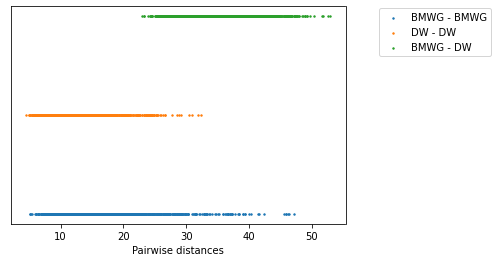

In [24]:
#plot distances along the real line and colour coded
plt.scatter(BMBM, [0] * BMBM.shape[0], s = 2, label = 'BMWG - BMWG')
plt.scatter(DWDW, [0.01] * DWDW.shape[0], s = 2, label = 'DW - DW')
plt.scatter(BMDW, [0.02] * BMDW.shape[0], s = 2, label = 'BMWG - DW')
plt.yticks([])
plt.xlabel('Pairwise distances')
plt.legend(loc = (1.1,0.77))

In [25]:
#compute the average trace for Big Money With Gardens and Double Witch Strategies
flat_trace_tmp = extended_traces_flat.drop(['Player', 'GameID'], axis = 1)
average_traces = flat_trace_tmp.groupby('PlayerName').apply(lambda row: round(row.mean())).reset_index()
new_col_names = {old_col: old_col + '_avg' for old_col in average_traces.columns[1:]}
new_col_names['PlayerName'] = 'AverageTraceForStrategy'
average_traces.rename(columns = new_col_names, inplace = True)
print(average_traces)

  AverageTraceForStrategy  GARDENS_R0_avg  WITCH_R0_avg  CURSE_R0_avg  \
0     BigMoneyWithGardens             0.0           0.0           0.0   
1             DoubleWitch             0.0           0.0           0.0   

   PROVINCE_R0_avg  DUCHY_R0_avg  ESTATE_R0_avg  GOLD_R0_avg  SILVER_R0_avg  \
0              0.0           0.0            3.0          0.0            1.0   
1              0.0           0.0            3.0          0.0            1.0   

   COPPER_R0_avg  ...  COPPER_R23_avg  GARDENS_R24_avg  WITCH_R24_avg  \
0            7.0  ...             7.0              3.0            0.0   
1            7.0  ...             7.0              0.0            2.0   

   CURSE_R24_avg  PROVINCE_R24_avg  DUCHY_R24_avg  ESTATE_R24_avg  \
0            7.0               2.0            0.0             3.0   
1            0.0               5.0            2.0             3.0   

   GOLD_R24_avg  SILVER_R24_avg  COPPER_R24_avg  
0           8.0             7.0             7.0  
1           5.

/var/folders/60/sk8yhxb56ld6twrcnr2njl3h0000gn/T/ipykernel_76256/2688685309.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  average_traces = flat_trace_tmp.groupby('PlayerName').apply(lambda row: round(row.mean())).reset_index()


In [31]:
#next calculate the distance between every play trace and the two average traces
dist_to_averages = {}
for player in ['BigMoneyWithGardens','DoubleWitch']:
    avg_trace = average_traces[average_traces['AverageTraceForStrategy'] == player].drop('AverageTraceForStrategy', axis = 1)
    avg_trace = pd.concat([avg_trace]*len(extended_traces_flat), ignore_index = True)
    avg_trace.reset_index()
    extended_traces_flat.reset_index()
    trace_pairs_to_avg = pd.concat([extended_traces_flat, avg_trace], axis = 1)

    #now we can compute the distance
    trace_pairs_to_avg['dist'] = trace_pairs_to_avg.apply(lambda row: dist_measure(row, card_types_BigMoneyWithGardens_vs_DoubleWitch,
                                                                                        maxNoOfRounds, "", "_avg"), axis = 1)
    #calculate averages and standard deviations
    trace_pairs_to_avg = trace_pairs_to_avg[['PlayerName','dist']]
    averages = trace_pairs_to_avg.groupby('PlayerName').mean()
    stds = trace_pairs_to_avg.groupby('PlayerName').std()
    
    print("Results when average trace is from " + player + ":")
    print(averages)
    print(stds)
    
    dist_to_averages[player] = trace_pairs_to_avg

Results when average trace is from BigMoneyWithGardens:
                         dist
PlayerName                   
BigMoneyWithGardens  12.02897
DoubleWitch          32.43445
                         dist
PlayerName                   
BigMoneyWithGardens  5.202421
DoubleWitch          2.163342
Results when average trace is from DoubleWitch:
                          dist
PlayerName                    
BigMoneyWithGardens  33.883902
DoubleWitch           9.296274
                         dist
PlayerName                   
BigMoneyWithGardens  4.063426
DoubleWitch          3.063825


In [37]:
print(dists_BMWG_AvgBMWG)

             PlayerName       dist
0   BigMoneyWithGardens   6.403124
1   BigMoneyWithGardens   6.324555
2   BigMoneyWithGardens   6.557439
3   BigMoneyWithGardens  11.575837
4   BigMoneyWithGardens  12.124356
5   BigMoneyWithGardens  10.344080
6   BigMoneyWithGardens  12.041595
7   BigMoneyWithGardens   7.000000
8   BigMoneyWithGardens  17.888544
9   BigMoneyWithGardens  13.152946
10  BigMoneyWithGardens  14.662878
11  BigMoneyWithGardens  15.748016
12  BigMoneyWithGardens  25.903668
13  BigMoneyWithGardens   9.055385
14  BigMoneyWithGardens   7.874008
15  BigMoneyWithGardens  14.317821
16  BigMoneyWithGardens  11.916375
17  BigMoneyWithGardens  15.033296
18  BigMoneyWithGardens  21.330729
19  BigMoneyWithGardens   6.557439
20  BigMoneyWithGardens  10.049876
21  BigMoneyWithGardens   9.591663
22  BigMoneyWithGardens   7.071068
23  BigMoneyWithGardens   6.557439
24  BigMoneyWithGardens  12.449900
25  BigMoneyWithGardens   8.000000
26  BigMoneyWithGardens  13.114877
27  BigMoneyWithGard

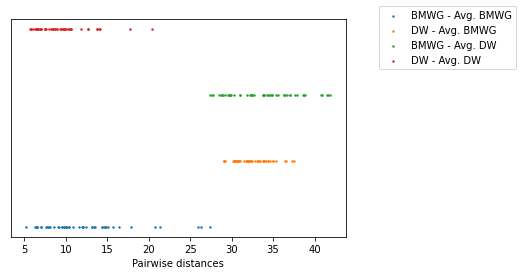

In [41]:
#plot distances to average traces along the real line and colour coded
dists_BMWG_AvgBMWG = dist_to_averages['BigMoneyWithGardens'][dist_to_averages['BigMoneyWithGardens']['PlayerName'] == 'BigMoneyWithGardens']
dists_DW_AvgBMWG = dist_to_averages['BigMoneyWithGardens'][dist_to_averages['BigMoneyWithGardens']['PlayerName'] == 'DoubleWitch']
dists_BMWG_AvgDW = dist_to_averages['DoubleWitch'][dist_to_averages['BigMoneyWithGardens']['PlayerName'] == 'BigMoneyWithGardens']
dists_DW_AvgDW = dist_to_averages['DoubleWitch'][dist_to_averages['BigMoneyWithGardens']['PlayerName'] == 'DoubleWitch']
plt.scatter(dists_BMWG_AvgBMWG['dist'], [0] * dists_BMWG_AvgBMWG.shape[0], s = 2, label = 'BMWG - Avg. BMWG')
plt.scatter(dists_DW_AvgBMWG['dist'], [0.01] * dists_DW_AvgBMWG.shape[0], s = 2, label = 'DW - Avg. BMWG')
plt.scatter(dists_BMWG_AvgDW['dist'], [0.02] * dists_BMWG_AvgDW.shape[0], s = 2, label = 'BMWG - Avg. DW')
plt.scatter(dists_DW_AvgDW['dist'], [0.03] * dists_DW_AvgDW.shape[0], s = 2, label = 'DW - Avg. DW')
plt.yticks([])
plt.xlabel('Pairwise distances')
plt.legend(loc = (1.1,0.77))





In [ ]:
#TODO:code not updated below this point

In [ ]:
#compute again our pairwise traces but this time also breakdown by opponent type
pairTraceDistsGranular = sym_trace_combos[['GameID_1','GameID_2','PlayerName_1', 'OpponentName_1', 'PlayerName_2', 'OpponentName_2','dist']]
pairTraceDistsGranular = sym_trace_combos.groupby(['GameID_1','GameID_2','PlayerName_1', 'OpponentName_1', 'PlayerName_2', 'OpponentName_2'])['dist'].sum()
df_pairTraceDistsGranular = pairTraceDistsGranular.reset_index()
print(df_pairTraceDistsGranular)

In [ ]:
results_means = pairTraceDistsGranular.groupby(['PlayerName_1', 'OpponentName_1', 'PlayerName_2', 'OpponentName_2']).mean()
print(results_means)
results_std = pairTraceDistsGranular.groupby(['PlayerName_1', 'OpponentName_1', 'PlayerName_2', 'OpponentName_2']).std()
print(results_std)

In [ ]:
#what is happening with the large distance value for BM vs BM? i.e. why the large amount of variance?
#look at piarwise traces for smallest and largest distance values
BMBM_data = df_pairwiseTraceDistances[(df_pairwiseTraceDistances['PlayerName_1'] == 'BigMoneyWithGardens') &
                                        (df_pairwiseTraceDistances['PlayerName_2'] == 'BigMoneyWithGardens')]

smallest_pairwise = BMBM_data.loc[BMBM_data['dist'].idxmin()]
largest_pairwise = BMBM_data.loc[BMBM_data['dist'].idxmax()]
print(smallest_pairwise)
print(largest_pairwise)

In [ ]:
def deck_evol_comparison(pairwise_deck_evols, cardTypes):
    #look at evolution of number of cards of each type per round
    noCardTypes = len(cardTypes)
    noOfSubplotsInXDirection = 3
    noOfSubplotsInYDirection = 3
    fig, axs = plt.subplots(noOfSubplotsInXDirection, noOfSubplotsInYDirection)
    for i in range(0,3):
        for j in range(0,3):
            cardIndex = 3*j + i
            cardType = cardTypes[cardIndex]
            card_col_1 = cardType + "_1"
            card_col_2 = cardType + "_2"
            axs[i,j].plot(pairwise_deck_evols['Round'], pairwise_deck_evols[card_col_1], label = 'Player_1')
            axs[i,j].plot(pairwise_deck_evols['Round'], pairwise_deck_evols[card_col_2], label = 'Player_2')
            axs[i,j].set_title(cardType)
            axs[i,j].set_xlabel('Round')
            fig.tight_layout() 

In [ ]:
#need to look at deck evolutions for each of these cases
largest_pairwise_decks =  sym_trace_combos[(sym_trace_combos['GameID_1'] == largest_pairwise['GameID_1']) 
                                           & (sym_trace_combos['GameID_2'] == largest_pairwise['GameID_2']) 
                                           & (sym_trace_combos['PlayerName_1'] == largest_pairwise['PlayerName_1']) 
                                           & (sym_trace_combos['PlayerName_2'] == largest_pairwise['PlayerName_2'])]
smallest_pairwise_decks =  sym_trace_combos[(sym_trace_combos['GameID_1'] == smallest_pairwise['GameID_1']) 
                                           & (sym_trace_combos['GameID_2'] == smallest_pairwise['GameID_2']) 
                                           & (sym_trace_combos['PlayerName_1'] == smallest_pairwise['PlayerName_1']) 
                                           & (sym_trace_combos['PlayerName_2'] == smallest_pairwise['PlayerName_2'])]
print(largest_pairwise_decks['dist'].sum())
print(smallest_pairwise_decks['dist'].sum())

In [ ]:
deck_evol_comparison(largest_pairwise_decks, card_types_BigMoneyWithGardens_vs_DoubleWitch)

In [ ]:
deck_evol_comparison(smallest_pairwise_decks, card_types_BigMoneyWithGardens_vs_DoubleWitch)

In [ ]:
#note similarity metric is getting artifically inflated by games that last longer? All games last 24 turns, but if
#difference in deck is quite large and game ends at round 20,this distance is copied for each of the remaining rounds?
#compare samllest and largest differences to see what is driving this.
#do games end quicker when the deck difference is bigger? Which then inflates the distance metric?